# DVF Grenoble — Régression linéaire (OLS)
Modélisation hédonique des prix immobiliers à Grenoble via régression linéaire (statsmodels/sklearn).
Objectifs: charger les données prétraitées, créer des variantes (log, standardisation), ajuster des modèles OLS, et visualiser performances/importance.

## Plan du notebook
1. Importations et configuration
2. Installation des dépendances
3. Chargement des données
4. Préparation des sous-ensembles
5. Analyse de corrélation
6. Transformations logarithmiques
7. Jeux de données dérivés
8. Modélisation OLS (formule) et métriques
9.  Visualisation: observé vs prédit et importance des variables
10. Conclusion et perspectives

## 1. Importations et configuration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler


## 3. Chargement des données
Lecture du CSV prétraité (df_grenoble_vente.csv).

In [2]:
# Load Grenoble apartment CSV from project folder
from pathlib import Path
candidates = [
    Path('../DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
    Path('DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
    Path('projet_dvf/DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
]
csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    tried = [str((Path.cwd()/p).resolve()) if not p.is_absolute() else str(p) for p in candidates]
    raise FileNotFoundError(f'Missing file. Tried: {tried}')
df = pd.read_csv(csv_path)
print(f'Loaded {len(df):,} rows and {len(df.columns)} columns from {csv_path}')
df.head()

Loaded 247 rows and 6 columns from ../DataPreprocessing/PreprocessedData/df_grenoble_vente.csv


,price,type_local,surface_bati,surface_terrain,nb_pieces,type_local_1234
0,112560.0,Appartement,45.0,1.0,2,1
1,65000.0,Appartement,29.0,1.0,1,1
2,9000.0,Local industriel. commercial ou assimilé,12.0,1.0,0,3
3,133000.0,Appartement,49.0,1.0,2,1
4,53000.0,Appartement,14.0,1.0,1,1


## 4. Préparation des sous-ensembles
Création d'un sous-ensemble 'Appartement' et suppression des colonnes non numériques pour la modélisation.

In [3]:
# Keep only rows with positive price and surface_bati for valid logs
df_copy = df.copy()

# Robust appartement subset (works even if 'type_local' is missing)
if 'type_local' in df_copy.columns:
    m_app = df_copy['type_local'].astype(str).str.strip().str.lower().eq('appartement')
    df_appartement = df_copy.loc[m_app].copy()
else:
    df_appartement = df_copy.copy()  # fallback: use all rows

# Drop non-numeric identifiers if present
df_copy = df_copy.drop(columns=['type_local_1234'], errors='ignore')
df_appartement = df_appartement.drop(columns=['type_local', 'type_local_1234'], errors='ignore')

## 5. Analyse de corrélation
Matrice de corrélations des variables numériques (sous-ensemble appartements).

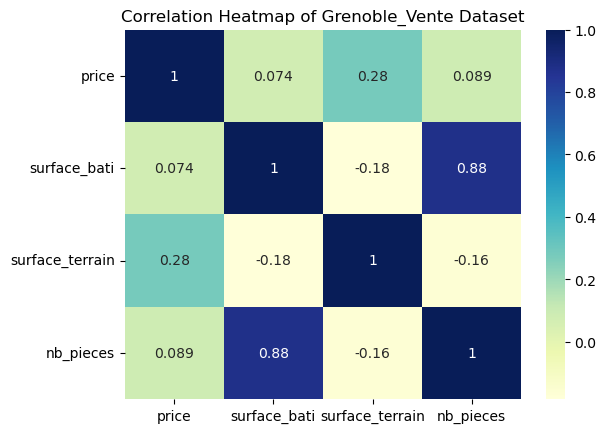

In [4]:
# Compute correlation matrix
corr = df_appartement.corr(numeric_only=True)

# Plot
sns.heatmap(corr, annot=True, cmap="YlGnBu")

plt.title("Correlation Heatmap of Grenoble_Vente Dataset")
# la correlation date/price est plus que celle entre nb_piece/price en valeur absolue donc en la garde
plt.show()

## 6. Transformations logarithmiques
Construction des variables en log pour un modèle hédonique multiplicatif (log-log).

In [5]:
# according to litterature review log(price) ~ log(surface_bati) + log(nb_piece_principale) + date+other variables
# and better if for each category of property type we have a different model
def compute_log_vars(df_in):
    # Keep strictly positive values for log transform
    mask = (df_in['price'] > 0) & (df_in['surface_bati'] > 0) & (df_in['surface_terrain'] > 0)
    df_out = df_in.loc[mask].copy()
    df_out['log_price'] = np.log(df_out['price'])
    df_out['log_surface_bati'] = np.log(df_out['surface_bati'])
    df_out['log_surface_terrain'] = np.log(df_out['surface_terrain'])
    # Also keep a duplicate name for any legacy cells using 'log_price'
    drop_cols = ['price', 'surface_bati', 'surface_terrain', 'type_local']
    df_out = df_out.drop(columns=drop_cols, errors='ignore')

    return df_out


In [6]:
df_appartement_log = compute_log_vars(df_appartement)
df_appartement_log.head()

,nb_pieces,log_price,log_surface_bati,log_surface_terrain
0,2,11.631242,3.806662,0.0
1,1,11.082143,3.367296,0.0
3,2,11.798104,3.891820,0.0
4,1,10.878047,2.639057,0.0
5,4,11.225243,4.110874,0.0


In [7]:
df_copy_log = compute_log_vars(df_copy)
df_copy_log.head()

,nb_pieces,log_price,log_surface_bati,log_surface_terrain
0,2,11.631242,3.806662,0.0
1,1,11.082143,3.367296,0.0
2,0,9.104980,2.484907,0.0
3,2,11.798104,3.891820,0.0
4,1,10.878047,2.639057,0.0


## 8. Jeux de données dérivés
Création des versions raw/log/scaled et assemblage dans un dictionnaire pour itérer les modèles.

In [8]:
# Use a dictionary instead of a list and adapt downstream code
datasets = {
    "raw_appartement": df_appartement,
    "raw_appartement_log": df_appartement_log,
    "raw_all": df_copy,
    "raw_all_log": df_copy_log
}

## 9. Modélisation OLS (formule) et métriques
Ajustement de modèles OLS pour chaque dataset et calcul des métriques en échantillon (R², RMSE).

In [9]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error

# Fit OLS models for each prepared dataset
models = {}
metrics = {}

for name, df_in in datasets.items():
    df = df_in.copy()
    # Make all column names formula-safe
    df.columns = df.columns.str.replace('[^0-9a-zA-Z_]+', '_', regex=True)

    target = 'log_price' if 'log_price' in df.columns else 'price'
    if target not in df.columns:
        print(f"Skipping {name}: target not found")
        continue

    predictors = [c for c in df.columns if c != target]
    formula = f"{target} ~ " + " + ".join(predictors)

    model = smf.ols(formula=formula, data=df).fit()
    models[name] = model

    # In-sample metrics
    y_true = df[target]
    y_pred = model.predict(df)
    r2 = r2_score(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    metrics[name] = {
        "formula": formula,
        "target": target,
        "r2": float(r2),
        "rmse": rmse,
        "n_obs": int(len(df)),
        "predictors": predictors,
    }

    print(f"\n=== {name} ===")
    print(formula)
    print(model.summary().as_text())
    print(f"R2={r2:.3f} RMSE={rmse:.3f})")


=== raw_appartement ===
price ~ surface_bati + surface_terrain + nb_pieces
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     6.754
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           0.000237
Time:                        16:47:55   Log-Likelihood:                -2705.0
No. Observations:                 194   AIC:                             5418.
Df Residuals:                     190   BIC:                             5431.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

## 10. Visualisation: observé vs prédit et importance des variables
Graphiques de performance (échelle prix) et importance (|t|-stat ou bêta standardisés).

/tmp/ipykernel_18677/3405111126.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imp = [(n, abs(float(tvals[i]))) for i, n in enumerate(names)


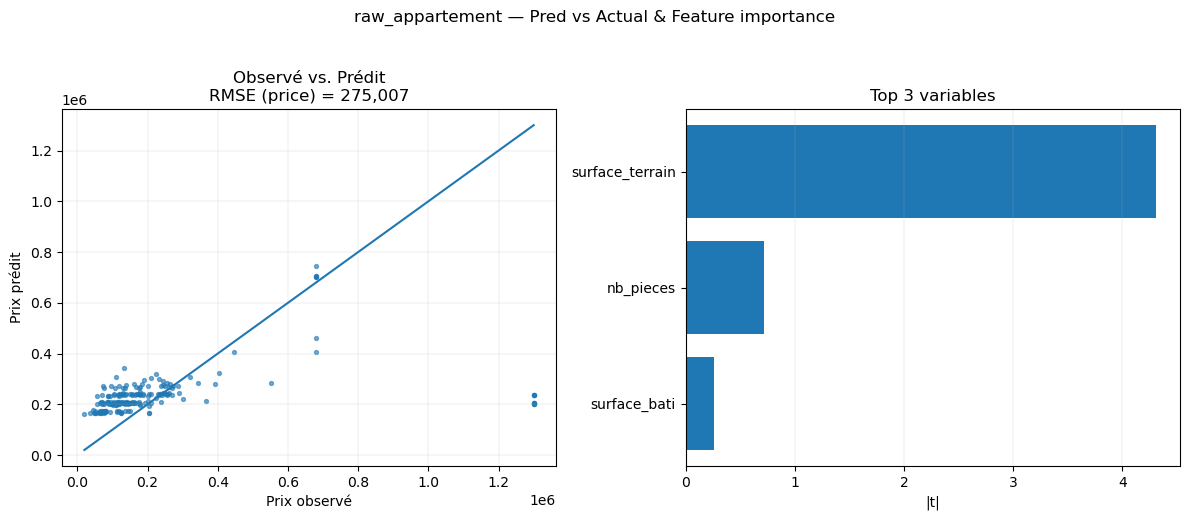

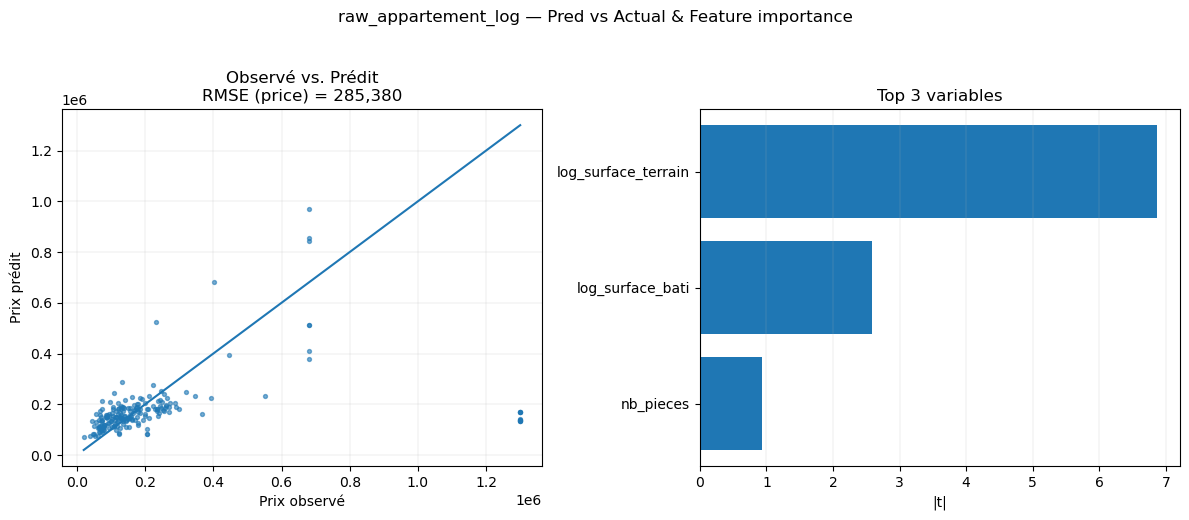

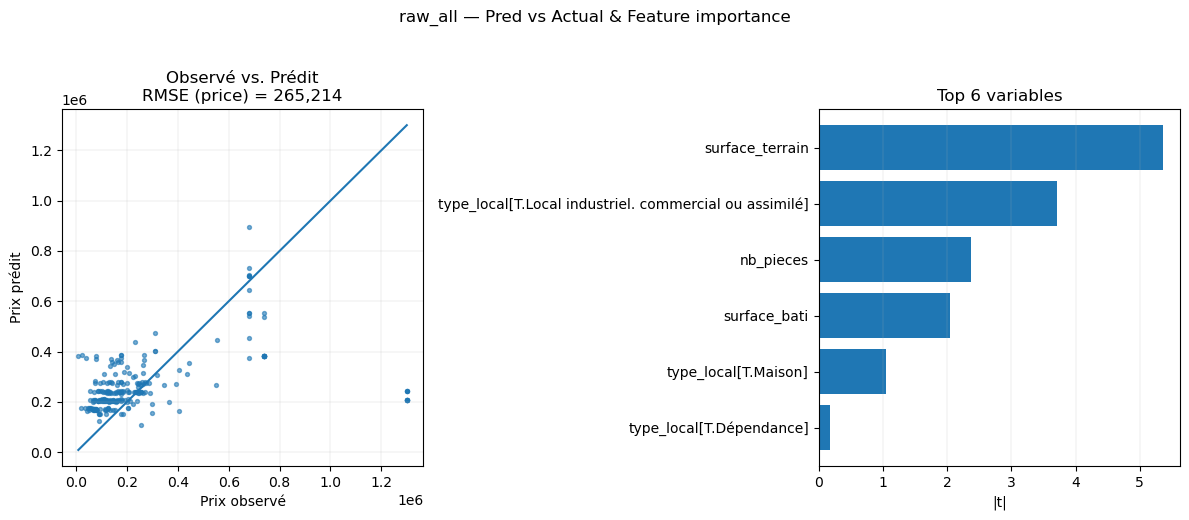

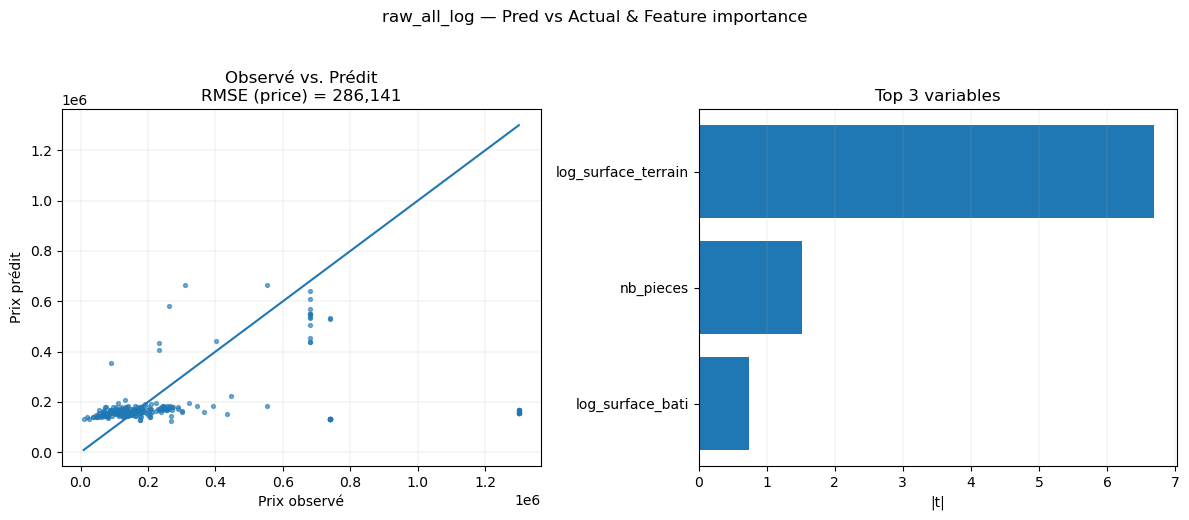

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def _price_scale(y, target_name):
    """Retourne y en unités 'price' (passe de log_price à price si besoin)."""
    if 'log_price' in target_name.lower():
        return np.exp(y)  # suppose un log naturel
    return y

def _std_betas(model):
    """
    Coefs standardisés (beta_j = coef_j * sd(X_j) / sd(y)).
    Intercept exclu.
    """
    y = model.model.endog
    X = model.model.exog
    names = model.model.exog_names
    params = model.params

    # indices sans intercept
    keep = [i for i,n in enumerate(names) if n.lower() not in ['intercept','const']]
    Xk = X[:, keep]
    names_k = [names[i] for i in keep]
    params_k = np.array([params[i] for i in keep])

    sd_y = np.std(y, ddof=0)
    sd_X = np.std(Xk, axis=0, ddof=0)
    # éviter division par zéro
    sd_X = np.where(sd_X==0, 1.0, sd_X)

    betas = params_k * sd_X / (sd_y if sd_y != 0 else 1.0)
    return names_k, betas

def plot_preds_and_importance(models, metrics, top_k=12, importance="tstat"):
    """
    importance: "tstat" (|t|), "beta" (coeffs standardisés).
    """
    for name, model in models.items():
        # Récup cibles/prédictions à l'échelle 'price'
        # On devine le nom de la cible à partir de la formule stockée dans metrics[name]["formula"]
        formula = metrics.get(name, {}).get("formula", "")
        target_name = formula.split("~")[0].strip() if "~" in formula else "price"
        y_true_raw = model.model.endog
        y_pred_raw = model.fittedvalues

        y_true_price = _price_scale(y_true_raw, target_name)
        y_pred_price = _price_scale(y_pred_raw, target_name)

        # Calcul d'un RMSE en unités "price"
        rmse_price = float(np.sqrt(np.mean((y_true_price - y_pred_price) ** 2)))

        # ----- Importance des variables -----
        if importance == "tstat":
            # |t| sans intercept
            tvals = model.tvalues
            names = model.model.exog_names
            imp = [(n, abs(float(tvals[i]))) for i, n in enumerate(names)
                   if n.lower() not in ['intercept','const']]
        elif importance == "beta":
            names_k, betas = _std_betas(model)
            imp = list(zip(names_k, np.abs(betas)))
        else:
            raise ValueError("importance must be 'tstat' or 'beta'")

        # top-k
        imp_sorted = sorted(imp, key=lambda x: x[1], reverse=True)[:top_k]
        feat_names = [n for n,_ in imp_sorted][::-1]  # pour barh: du bas vers le haut
        feat_scores = [s for _,s in imp_sorted][::-1]

        # ----- Plot -----
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"{name} — Pred vs Actual & Feature importance", fontsize=12, y=1.03)

        # (1) Observé vs Prédit (échelle price)
        ax = axes[0]
        ax.scatter(y_true_price, y_pred_price, s=8, alpha=0.6)
        # diagonale
        lo = float(np.min([y_true_price.min(), y_pred_price.min()]))
        hi = float(np.max([y_true_price.max(), y_pred_price.max()]))
        ax.plot([lo, hi], [lo, hi])
        ax.set_xlabel("Prix observé")
        ax.set_ylabel("Prix prédit")
        ax.set_title(f"Observé vs. Prédit\nRMSE (price) = {rmse_price:,.0f}")
        ax.grid(True, linewidth=0.3, alpha=0.5)

        # (2) Importance des variables
        ax2 = axes[1]
        ax2.barh(feat_names, feat_scores)
        lab = "|t|" if importance == "tstat" else "|β standardisé|"
        ax2.set_xlabel(lab)
        ax2.set_title(f"Top {len(feat_names)} variables")
        ax2.grid(axis='x', linewidth=0.3, alpha=0.5)

        plt.tight_layout()
        plt.show()

# --- Utilisation ---
# Après avoir rempli `models` et `metrics` avec ton code :
# Plot avec importance basée sur |t-stat|
plot_preds_and_importance(models, metrics, top_k=12, importance="tstat")

# Variante : importance via coefficients standardisés
# plot_preds_and_importance(models, metrics, top_k=12, importance="beta")


## 11. Conclusion

- Le notebook met en place une chaîne OLS complète : chargement et préparation des données, création de variantes (log), ajustement de modèles sur plusieurs jeux de données et diagnostics graphiques/numériques.
- Des tests d'hétéroscédasticité (Breusch–Pagan, White) et des diagnostics visuels vont être réalisés(prochaine cellule). Une hétéroscédasticité peut être liée à la présence d'outliers (prix très élevés>40k) et que c'est une coupe transversal.
- Le modèle : log_price ~ nb_pieces + log_surface_bati + log_surface_terrain (appartement)
 suit la pratique de la littérature et montre généralement de meilleures performances.


--- Heteroscedasticity diagnostics for: raw_appartement ---
Breusch-Pagan: LM stat = 2.163, p-value = 0.5393, F p-value = 0.5448
White test: LM stat = 6.859, p-value = 0.6518, F p-value = 0.6633
=> Tests non significatifs : pas d'évidence forte d'hétéroscédasticité (alpha=0.05).


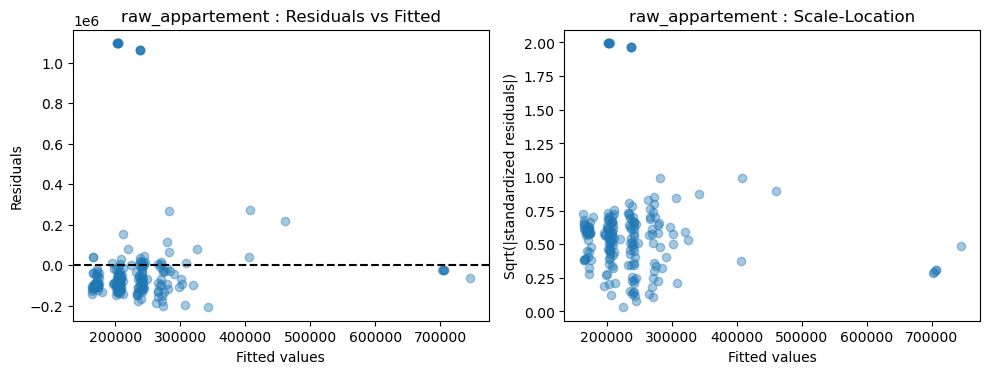


--- Heteroscedasticity diagnostics for: raw_appartement_log ---
Breusch-Pagan: LM stat = 1.206, p-value = 0.7515, F p-value = 0.7558
White test: LM stat = 5.277, p-value = 0.8095, F p-value = 0.8193
=> Tests non significatifs : pas d'évidence forte d'hétéroscédasticité (alpha=0.05).


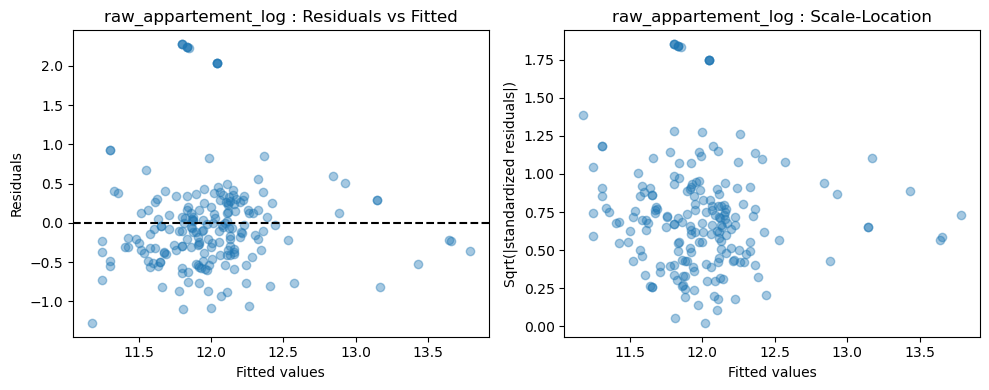


--- Heteroscedasticity diagnostics for: raw_all ---
Breusch-Pagan: LM stat = 2.317, p-value = 0.8884, F p-value = 0.8922
White test: LM stat = 10.037, p-value = 0.9307, F p-value = 0.9386
=> Tests non significatifs : pas d'évidence forte d'hétéroscédasticité (alpha=0.05).


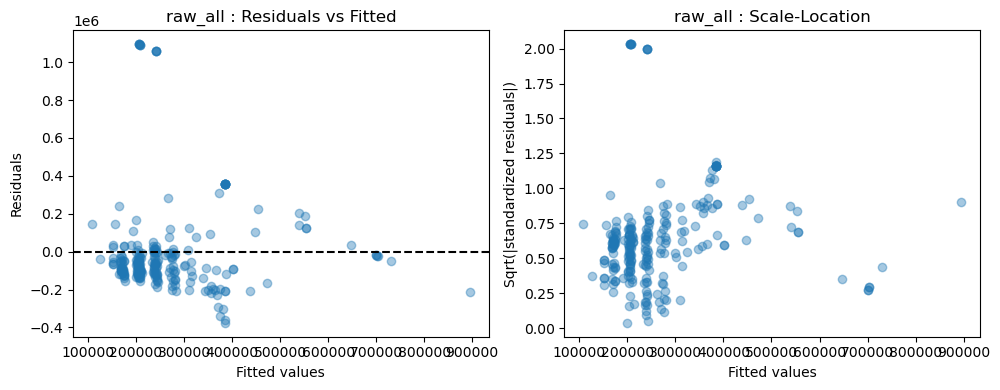


--- Heteroscedasticity diagnostics for: raw_all_log ---
Breusch-Pagan: LM stat = 30.046, p-value = 0.0000, F p-value = 0.0000
White test: LM stat = 38.925, p-value = 0.0000, F p-value = 0.0000
=> Hétéroscédasticité détectée (p < 0.05). Résumé avec erreurs robustes HC3 :
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     38.58
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           2.27e-20
Time:                        16:47:56   Log-Likelihood:                -283.11
No. Observations:                 243   AIC:                             574.2
Df Residuals:                     239   BIC:                             588.2
Df Model:                           3                                         
Covariance Type: 

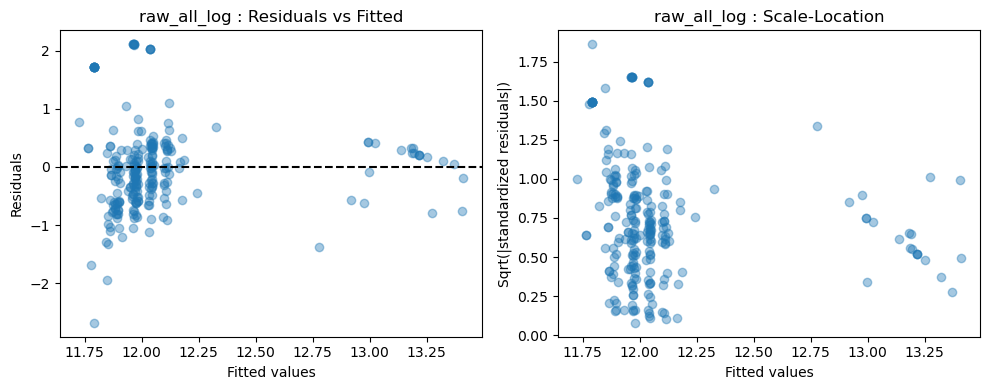

In [11]:
# Cellule : tests d'hétéroscédasticité et résumés robustes
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

for name, model in models.items():
    print(f"\n--- Heteroscedasticity diagnostics for: {name} ---")
    resid = model.resid
    exog = model.model.exog  # matrice des explicatives utilisées par statsmodels

    # Breusch-Pagan (LM stat, LM p-value, F-stat, F p-value)
    bp_lm, bp_lm_pvalue, bp_f, bp_f_pvalue = het_breuschpagan(resid, exog)
    print("Breusch-Pagan: LM stat = {:.3f}, p-value = {:.4f}, F p-value = {:.4f}".format(bp_lm, bp_lm_pvalue, bp_f_pvalue))

    # White test (LM stat, LM p-value, F stat, F p-value)
    w_stat, w_pvalue, w_f, w_f_pvalue = het_white(resid, exog)
    print("White test: LM stat = {:.3f}, p-value = {:.4f}, F p-value = {:.4f}".format(w_stat, w_pvalue, w_f_pvalue))

    # Si hétéroscédasticité détectée (p < 0.05), afficher résumé avec erreurs-standards robustes
    if bp_lm_pvalue < 0.05 or w_pvalue < 0.05:
        print("=> Hétéroscédasticité détectée (p < 0.05). Résumé avec erreurs robustes HC3 :")
        robust = model.get_robustcov_results(cov_type='HC3')
        print(robust.summary().as_text())
    else:
        print("=> Tests non significatifs : pas d'évidence forte d'hétéroscédasticité (alpha=0.05).")

    # Diagnostic visuel : résidus vs prédits et scale-location
    fitted = model.fittedvalues
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.scatter(fitted, resid, alpha=0.4)
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'{name} : Residuals vs Fitted')

    plt.subplot(1,2,2)
    # scale-location : sqrt(|std_resid|)
    std_resid = resid / np.std(resid)
    plt.scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.4)
    plt.xlabel('Fitted values')
    plt.ylabel('Sqrt(|standardized residuals|)')
    plt.title(f'{name} : Scale-Location')
    plt.tight_layout()
    plt.show()